In [1]:
basedir = '/home/abhinavgupta0110/NeuralODEs_ROM_Closure'

import os

is_google_colab = False
is_use_GPU = False

### Mount the drive

In [2]:
if is_use_GPU:
    gpu_info = !nvidia-smi
    gpu_info = '\n'.join(gpu_info)
    if gpu_info.find('failed') >= 0:
        print('No GPU found!')
    else:
        print(gpu_info)

if is_google_colab:
    from google.colab import drive
    drive.mount('/content/drive')

    %pip install quadpy
    
os.chdir(os.path.join(basedir, 'neuralClosureModels'))

### Load modules

In [3]:
from src.utilities.DDE_Solver import ddeinttf 
import src.advec_diff_case.advec_diff_eqn_modcall as adeq
import src.advec_diff_case.rom_advec_diff_modcall as rom

from IPython.core.debugger import set_trace

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

tf.keras.backend.set_floatx('float32')

## Define some useful classes

### Initial conditions

In [4]:
class initial_cond:

    def __init__(self, x, app):
        self.x = x
        self.app = app

    def __call__(self, t):
        u0 = self.x / (1. + np.sqrt(1./self.app.t0) * np.exp(self.app.Re * self.x**2 / 4., dtype = np.float64))
        return tf.convert_to_tensor([u0], dtype=tf.float32)

In [5]:
class create_mean_modes:
    def __init__(self, fom_sol, app, t):
        self.fom_sol = fom_sol
        self.app = app
        self.t = t

    def __call__(self):

        u_analy = tf.transpose(self.fom_sol)

        u_mean = tf.expand_dims(tf.reduce_mean(u_analy, axis=-1), axis=1)
        
        S, U, V = tf.linalg.svd(u_analy - tf.tile(u_mean, [1, len(self.t)]))

        ui = U[:, 0:self.app.rom_dims]

        return u_mean, ui

## Main part starts here

### User-defined parameters, create objects, and solve the full order model

In [6]:
app = rom.rom_eqn_args(T = 2.5, nt = 250, L = 1., nx = 100, Re = 1000, u_bc_0 = 0., u_bc_L =0., rom_dims = 3, rom_batch_size = 1, ad_eq_batch_size = 1)

x = tf.linspace(0., app.L, app.nx)
t = tf.linspace(0., app.T, app.nt) # Time array

u0 = initial_cond(x, app) # Initial conditions

op = adeq.operators(app)

%prun u_fom = ddeinttf(adeq.ad_eqn(op, app), u0, t)

print('FOM done!')

 FOM done!


### Solve th ROM model and plot

In [7]:
u_mean, ui = create_mean_modes(tf.squeeze(u_fom, axis=1), app, t)()

ai_t0 = rom.initial_cond_rom(u0, ui, u_mean)

ai = ddeinttf(rom.rom_ad_eqn(um = u_mean, ui = ui, op = op, app = app), ai_t0, t)

u_rom = tf.tile(tf.expand_dims(tf.transpose(u_mean, perm=[1, 0]), axis=0), [app.nt, app.rom_batch_size, 1]) \
            + tf.cast(tf.einsum('ab, cdb -> cda', tf.cast(ui, tf.float64), tf.cast(ai, tf.float64)), tf.float32)

print('ROM done!')

ROM done!


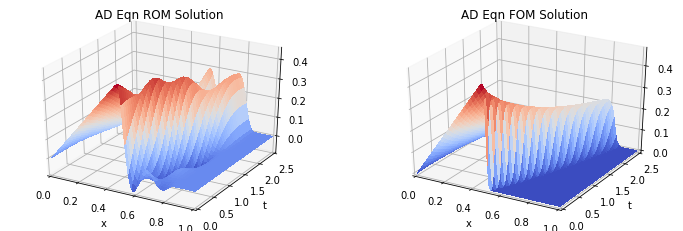

In [8]:
fig = plt.figure(figsize=(12, 4), facecolor='white')
ax_u = fig.add_subplot(121, projection='3d')
ax_u_analy = fig.add_subplot(122, projection='3d')

X, T = np.meshgrid(x.numpy(), t.numpy())

ax_u.cla()
ax_u.set_title('AD Eqn ROM Solution')
ax_u.set_xlabel('x')
ax_u.set_ylabel('t')
ax_u.plot_surface(X, T, tf.squeeze(u_rom, axis=1).numpy(), cmap=cm.coolwarm,
                    linewidth=0, antialiased=False)
ax_u.set_xlim(x[0], x[-1])
ax_u.set_ylim(t[0], t[-1])

ax_u_analy.cla()
ax_u_analy.set_title('AD Eqn FOM Solution')
ax_u_analy.set_xlabel('x')
ax_u_analy.set_ylabel('t')
ax_u_analy.plot_surface(X, T, tf.squeeze(u_fom, axis=1).numpy(), cmap=cm.coolwarm,
                    linewidth=0, antialiased=False)
ax_u_analy.set_xlim(x[0], x[-1])
ax_u_analy.set_ylim(t[0], t[-1])

fig.show()

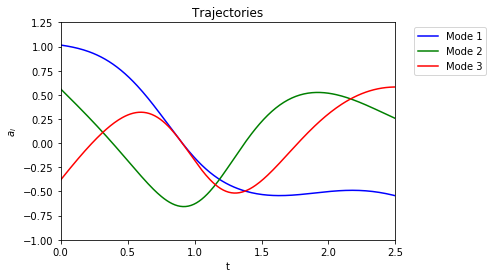

In [11]:
fig = plt.figure(figsize=(6, 4), facecolor='white')
ax = fig.add_subplot(111)
colors = ['b', 'g', 'r', 'k', 'c', 'm']

ax.cla()
ax.set_title('Trajectories')
ax.set_xlabel('t')
ax.set_ylabel('$a_i$')
ax.set_xlim(min(t.numpy()), max(t.numpy()))
ax.set_ylim(-1., 1.25)

for i in range(app.rom_dims):
    ax.plot(t.numpy(), ai.numpy()[:, 0, i], colors[i % app.rom_dims]+'-', label = 'Mode '+str(i+1))
    
ax.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.show() 